In [1]:
import networkx as nx
import json
from base64 import b64decode
import time

start_time = time.time()
data = []
with open('C:/studia/TASS/maven-artifacts-dependencies-analysis/data/mvn-deps-fixed.csv', 'r') as file:
    i = 0
    for line in file:
        i += 1
        artifactId, groupId, version, deps = line.split('\t')
        deps = json.loads(b64decode(deps))
        data += [(artifactId, groupId, version, deps)]
print("--- {0:.2f} seconds ---".format(time.time() - start_time))
print("read " + str(i) + " nodes")

--- 9.19 seconds ---
read 340913 nodes


In [3]:
i, j, m, n, o = (0,)*5

start_time = time.time()
G = nx.Graph()
for d in data:
    i += 1
    artifactId, groupId, version, deps = d
    if G.has_node("{}_{}_{}".format(artifactId, groupId, version)):
        m += 1
    G.add_node("{}_{}_{}".format(artifactId, groupId, version))
    for dep in deps:
        j += 1
        if not G.has_node("{}_{}_{}".format(dep["artifactid"], dep["groupid"], dep["version"])):
            o += 1
        if G.has_edge("{}_{}_{}".format(artifactId, groupId, version),
                      "{}_{}_{}".format(dep["artifactid"], dep["groupid"], dep["version"])):
            n += 1
        G.add_edge("{}_{}_{}".format(artifactId, groupId, version),
                   "{}_{}_{}".format(dep["artifactid"], dep["groupid"], dep["version"]))
print("--- {0:.2f} seconds ---".format(time.time() - start_time))

print("Graph has been created.")  
#nx.write_pajek(G, 'data/mvn-deps.net')
#print("Graph has been exported to Pajek format (data/mvn-deps.net).")  

G_size = G.size()
G_order = G.order()

print("Duplicated " + str(m) + " nodes defined as lines in file.")
print("Created " + str(o) + " nodes from dependencies definitions.")
print("Duplicated " + str(n) + " edges.")
print("In the file there were " + str(i) + " nodes and " + str(j) + 
      " edges and some of them were duplicated")
print("Created graph has " + str(G_order) + " nodes and " + str(G_size) + " edges.")
print("The difference between number of nodes in file (" + str(i) + 
      ") and number of nodes in created graph (" + str(G_order) + ") equals " + str(i - G_order) + 
      ". Is it equal to (number of duplicated nodes (" + str(m) + 
      ") minus number of nodes created from dependencies (" + str(o) + ") [" + 
      str(m - o) + "])? " + str((i-G_order) == (m-o)))
print("The difference between number of edges in file (" + str(j) + 
      ") and number of edges in created graph (" + str(G_size) + ") equals " + str(j - G_size) + 
      ". Is it equal to number of duplicated edges (" + str(n) + ")? " + str((j-G_size) == n))

--- 16.32 seconds ---
Graph has been created.
Duplicated 234877 nodes defined as lines in file.
Created 97593 nodes from dependencies definitions.
Duplicated 712700 edges.
In the file there were 340913 nodes and 1941810 edges and some of them were duplicated
Created graph has 203629 nodes and 1229110 edges.
The difference between number of nodes in file (340913) and number of nodes in created graph (203629) equals 137284. Is it equal to (number of duplicated nodes (234877) minus number of nodes created from dependencies (97593) [137284])? True
The difference between number of edges in file (1941810) and number of edges in created graph (1229110) equals 712700. Is it equal to number of duplicated edges (712700)? True


In [4]:
print("Is graph connected? " + str(nx.is_connected(G)))
start_time = time.time()
n = nx.number_connected_components(G)
print("The graph has " + str(n) + " connected components")
largest_cc = max(nx.connected_component_subgraphs(G), key=len)
largest_cc_size = largest_cc.size()
largest_cc_order = largest_cc.order()
print("--- {0:.2f} seconds ---".format(time.time() - start_time))
print(("Largest connected component order (number of nodes): " + str(largest_cc_order) + 
      " ({0:.3f} of whole graph)").format(largest_cc_order / G_order))
print("Largest connected component size (number of edges): " + str(largest_cc_size) + 
      " ({0:.3f} of whole graph)".format(largest_cc_size / G_size))

Is graph connected? False


The graph has 21495 connected components


--- 16.07 seconds ---
Largest connected component order (number of nodes): 176408 (0.866 of whole graph)
Largest connected component size (number of edges): 1219622 (0.992 of whole graph)


Coefficient: 0.336336288502


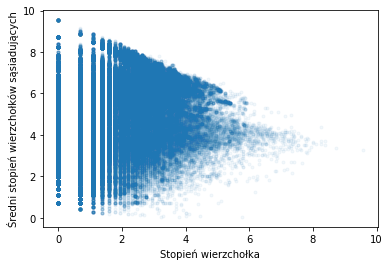

In [16]:
import scipy as sp
start_time = time.time()
print("{0:.3f}".format(nx.degree_pearson_correlation_coefficient(largest_cc)))
print("--- {0:.2f} seconds ---".format(time.time() - start_time))
xy = nx.node_degree_xy(largest_cc)
x, y = zip(*xy)
avg_deg_conn = nx.average_degree_connectivity(largest_cc)
avg_neighbor_degree = nx.average_neighbor_degree(largest_cc)

Coefficient: 0.336336288502


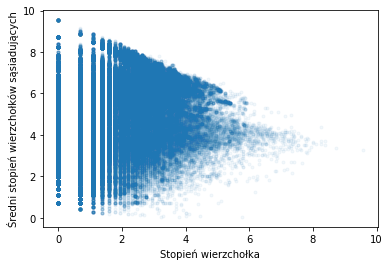

In [9]:
import matplotlib.pyplot as plt

plt.plot(x, y, '.', alpha=0.05)
plt.xlabel('Stopień wierzchołka')
plt.ylabel('Średni stopień wierzchołków sąsiadujących')
plt.show()

Coefficient: 0.336336288502


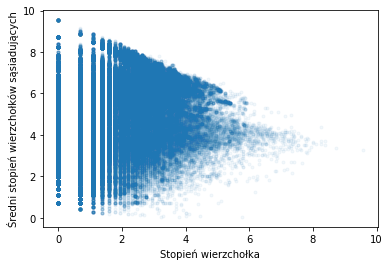

In [ ]:
avg_neighbors_degrees = []
for node_name, avg_degree in avg_neighbor_degree.items():
    avg_neighbors_degrees.append((largest_cc.degree(node_name), avg_degree))
node_deg, neighbors_avg_deg = zip(*avg_neighbors_degrees)
plt.loglog(node_deg, neighbors_avg_deg, '.', alpha=0.05)
plt.xlabel('Stopień wierzchołka')
plt.ylabel('Średni stopień wierzchołków sąsiadujących')
plt.show()


Coefficient: 0.336336288502


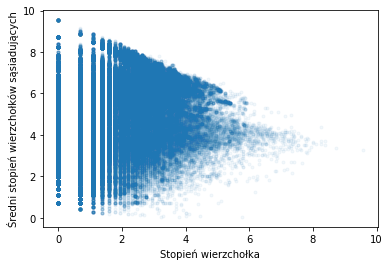

In [29]:
from math import log
x_deg_log = list(map(log, node_deg))
y_avg_log = list(map(log, neighbors_avg_deg))
print(x_deg_log[:10])

Coefficient: 0.336336288502


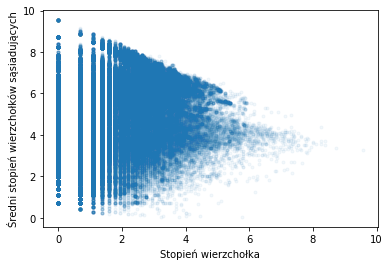

In [ ]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(x_deg_log, y_avg_log)
print("Coefficient: " + str(slope) + "; intercept: " + str(intercept))
plt.plot(x_deg_log, y_avg_log, '.', alpha=0.05)
plt.xlabel('Stopień wierzchołka')
plt.ylabel('Średni stopień wierzchołków sąsiadujących')
plt.show()


Pearson's correlation coefficient: -0.353


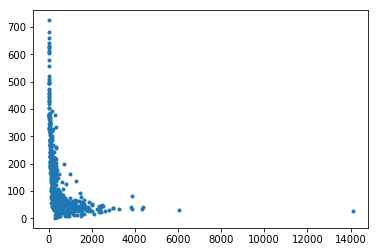

In [ ]:

data_plot = sorted(avg_deg_conn.items())
x, y = zip(*data_plot)

print("Pearson's correlation coefficient: {corr:.3f}".format(corr=sp.stats.pearsonr(x, y)[0]))

plt.plot(x, y, '.')
plt.xlabel('Stopień wierzchołka')
plt.ylabel('Średni stopień wierzchołków sąsiadujących')
plt.show()

Pearson's correlation coefficient: -0.432


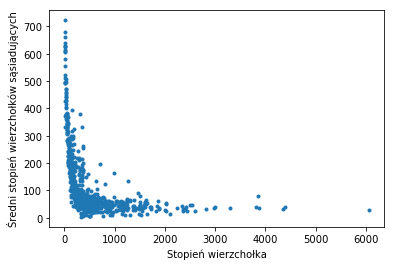

In [10]:
import matplotlib.pyplot as plt
import scipy as sp
data_plot = sorted(avg_deg_conn.items())
x, y = zip(*data_plot)
x_no_outliers = x[:-1]
y_no_outliers = y[:-1]

print("Pearson's correlation coefficient: {corr:.3f}".format(
    corr=sp.stats.pearsonr(x_no_outliers, y_no_outliers)[0]))

plt.plot(x_no_outliers, y_no_outliers, '.')
plt.xlabel('Stopień wierzchołka')
plt.ylabel('Średni stopień wierzchołków sąsiadujących')
plt.show()

Pearson's correlation coefficient: -0.776


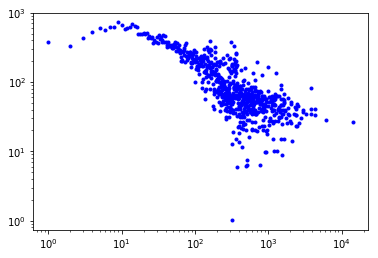

In [70]:
from math import log
x, y = zip(*data_plot)

x_log = tuple(map(log, x))
y_log = tuple(map(log, y))
print("Pearson's correlation coefficient: {corr:.3f}".format(
    corr=sp.stats.pearsonr(x_log, y_log)[0]))

plt.loglog(x, y, 'b.')
plt.xlabel('Stopień wierzchołka (wartości zlogartmowane)')
plt.ylabel('Średni stopień wierzchołków sąsiadujących (wartości zlogartmowane)')
plt.show()